# **PyTorch**

# Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [ ]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    valid_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        normalize,
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            normalize,
        ])

    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=train_transform)

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=2, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=2, pin_memory=True)

    return train_loader, valid_loader

def get_test_loader(data_dir, batch_size, shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=2, pin_memory=True)

    return data_loader

100%|██████████| 170M/170M [00:05<00:00, 30.2MB/s]


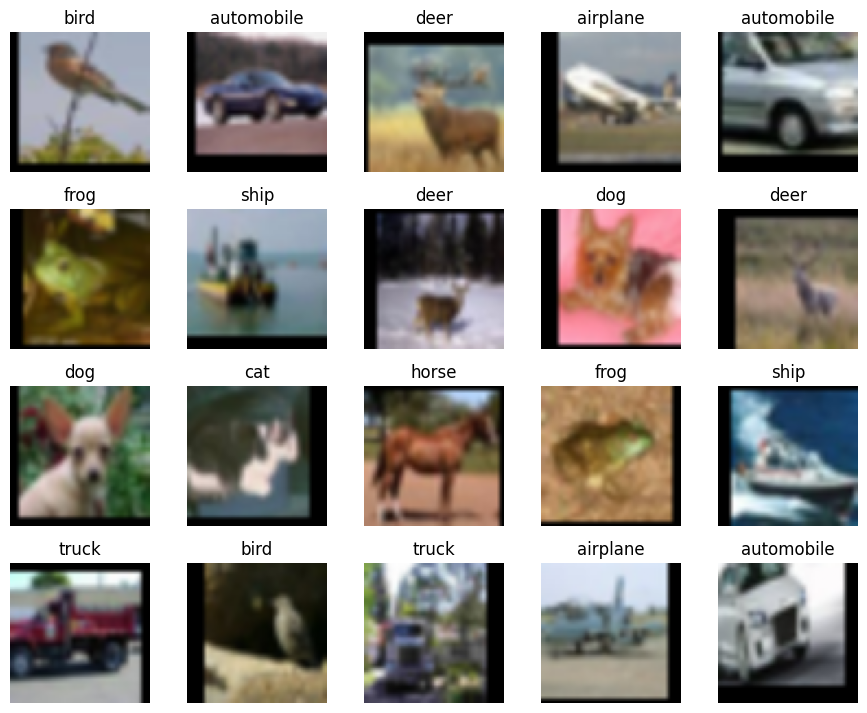

In [ ]:
train_loader, valid_loader = get_train_valid_loader(
    data_dir='./data',
    batch_size=32,
    augment=True,
    random_seed=42
)

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    img = img.clamp(0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.figure(figsize=(9,9))
for i in range(20):
    ax = plt.subplot(5, 5, i+1)
    imshow(images[i].cpu())
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# AlexNet Model

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        dummy_input = torch.zeros(1, 3, 64, 64)
        out = self.layer1(dummy_input)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        self.flattened_size = out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flattened_size, 1024),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU())
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 10
num_epochs = 35
batch_size = 32
learning_rate = 0.001

model = AlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)

# Data
train_loader, valid_loader = get_train_valid_loader(
    data_dir='./data', batch_size=batch_size, augment=True, random_seed=42)

test_loader = get_test_loader(data_dir='./data', batch_size=batch_size)

# Training and Validation

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

total_step = len(train_loader)

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    running_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / total_step
    train_acc = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Steps: {total_step}, Images: {train_total}, '
          f'Train Accuracy: {train_acc:.2f}%, Train Loss: {avg_train_loss:.4f},'
          f'Validation Accuracy: {val_acc:.2f}%, Validation Loss: {avg_val_loss:.4f}')

Epoch [1/30], Steps: 1407, Images: 45000, Train Accuracy: 24.51%, Train Loss: 1.9865,Validation Accuracy: 27.50%, Validation Loss: 1.8121
Epoch [2/30], Steps: 1407, Images: 45000, Train Accuracy: 30.80%, Train Loss: 1.7796,Validation Accuracy: 36.80%, Validation Loss: 1.6416
Epoch [3/30], Steps: 1407, Images: 45000, Train Accuracy: 41.05%, Train Loss: 1.5591,Validation Accuracy: 42.84%, Validation Loss: 1.5368
Epoch [4/30], Steps: 1407, Images: 45000, Train Accuracy: 47.07%, Train Loss: 1.4309,Validation Accuracy: 49.54%, Validation Loss: 1.3209
Epoch [5/30], Steps: 1407, Images: 45000, Train Accuracy: 50.23%, Train Loss: 1.3605,Validation Accuracy: 55.12%, Validation Loss: 1.2046
Epoch [6/30], Steps: 1407, Images: 45000, Train Accuracy: 53.65%, Train Loss: 1.2788,Validation Accuracy: 58.36%, Validation Loss: 1.1262
Epoch [7/30], Steps: 1407, Images: 45000, Train Accuracy: 55.57%, Train Loss: 1.2370,Validation Accuracy: 58.38%, Validation Loss: 1.1594
Epoch [8/30], Steps: 1407, Images:

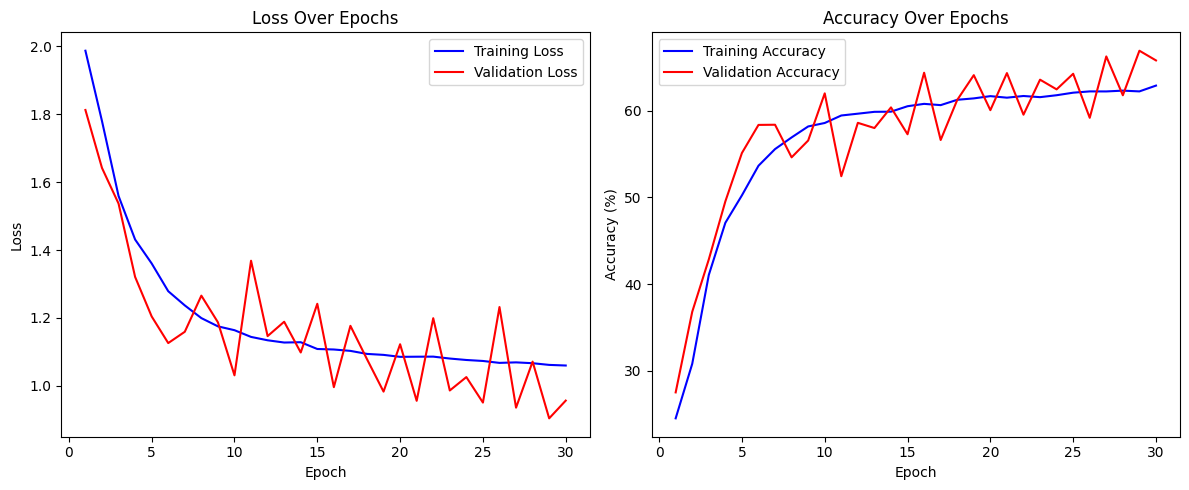

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Testing and Results

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(f'Test Accuracy: {100 * correct / total:.2f}% on {total} test images')

Test Accuracy: 65.77% on 10000 test images
